#OpenVINO影像分類範例_開閤眼偵測

歐尼克斯實境互動工作室 OmniXRI Jack, 2021.7.20

# 1. 安裝Intel OpenVINO工具包
以apt方式安裝OpenVINO，安裝版本為 2021.3.394  
預設安裝路徑為/opt/intel/OpenVINO_2021.3.394，系統會自建出/opt/intel/OpenVINO_2021捷徑名稱，後續可使用這個較短捷徑名稱。

In [1]:
# 顯示目前工作目錄
!pwd
# 取得OpenVINO 2021公開金錀
!wget https://apt.repos.intel.com/openvino/2021/GPG-PUB-KEY-INTEL-OPENVINO-2021 
# 加入OpenVINO公開金錀到系統金錀群中
!apt-key add GPG-PUB-KEY-INTEL-OPENVINO-2021 
# 建立更新安裝清單檔案
!touch /etc/apt/sources.list.d/intel-openvino-2021.list
# 將下載指令加入安裝清單中
!echo "deb https://apt.repos.intel.com/openvino/2021 all main" >> /etc/apt/sources.list.d/intel-openvino-2021.list
# 更新系統
!apt update
# 安裝OpenVINO到虛擬機系統中
!apt install intel-openvino-dev-ubuntu18-2021.3.394
# 列出安裝路徑下內容進行確認
!ls /opt/intel

/content
--2021-07-19 16:11:14--  https://apt.repos.intel.com/openvino/2021/GPG-PUB-KEY-INTEL-OPENVINO-2021
Resolving apt.repos.intel.com (apt.repos.intel.com)... 104.102.229.90, 2600:1408:20:c8d::4b23, 2600:1408:20:c89::4b23
Connecting to apt.repos.intel.com (apt.repos.intel.com)|104.102.229.90|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 939 [binary/octet-stream]
Saving to: ‘GPG-PUB-KEY-INTEL-OPENVINO-2021.1’

GPG-PUB-KEY-INTEL-O 100%[===================>]     939  --.-KB/s    in 0s      

2021-07-19 16:11:14 (236 MB/s) - ‘GPG-PUB-KEY-INTEL-OPENVINO-2021.1’ saved [939/939]

OK
Hit:1 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:2 https://apt.repos.intel.com/openvino/2021 all InRelease
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86

# 2.下載模型

OpenVINO Open Model Zoo (Public pretrained models) 中提供了約有70多種現成的影像分類模型，如下列網址所示。  
https://docs.openvinotoolkit.org/latest/classification_models_public.html  

模型名稱包括：alexnet, anti-spoof-mn3, caffenet, densenet-121, densenet-121-caffe2, densenet-121-tf, densenet-161, densenet-161-tf, densenet-169, densenet-169-tf, densenet-201, densenet-201-tf, dla-34, efficientnet-b0, efficientnet-b0-pytorch, efficientnet-b0_auto_aug, efficientnet-b5, efficientnet-b5-pytorch, efficientnet-b7-pytorch, efficientnet-b7_auto_aug, googlenet-v1, googlenet-v1-tf, googlenet-v2, googlenet-v2-tf, googlenet-v3, googlenet-v3-pytorch, googlenet-v4-tf, hbonet-0.25, hbonet-0.5, hbonet-1.0, inception-resnet-v2-tf, mobilenet-v1-0.25-128, mobilenet-v1-0.50-160, mobilenet-v1-0.50-224, mobilenet-v1-1.0-224, mobilenet-v1-1.0-224-tf, mobilenet-v2, mobilenet-v2-1.0-224, mobilenet-v2-1.4-224, mobilenet-v2-pytorch, mobilenet-v3-large-1.0-224-tf, mobilenet-v3-small-1.0-224-tf, octave-densenet-121-0.125, octave-resnet-101-0.125, octave-resnet-200-0.125, octave-resnet-26-0.25, octave-resnet-50-0.125, octave-resnext-101-0.25, octave-resnext-50-0.25, octave-se-resnet-50-0.125, open-closed-eye-0001, regnetx-3.2gf, resnest-50-pytorch, resnet-18-pytorch, resnet-34-pytorch, resnet-50-caffe2, resnet-50-pytorch, resnet-50-tf, rexnet-v1-x1.0, se-inception, se-resnet-101, se-resnet-152, se-resnet-50, se-resnext-101, se-resnext-50, shufflenet-v2-x1.0, squeezenet1.0, squeezenet1.1, squeezenet1.1-caffe2, vgg16, vgg19, vgg19-caffe2.  

這裡選用 **--name open-closed-eye-0001** （可自行變更所需模型名稱，這個模型為onnx格式）

In [2]:
!source /opt/intel/openvino_2021/bin/setupvars.sh && \
python3 /opt/intel/openvino_2021/deployment_tools/tools/model_downloader/downloader.py --name open-closed-eye-0001
!ls public/open-closed-eye-0001/

[setupvars.sh] OpenVINO environment initialized
################|| Downloading open-closed-eye-0001 ||################

========== Downloading /content/public/open-closed-eye-0001/open-closed-eye.onnx
... 100%, 45 KB, 3433 KB/s, 0 seconds passed

FP16  FP32  open-closed-eye.onnx


# 3.模型轉換

如果下載的是Intel Pretrained Model則不需轉換就自帶IR檔(xml,bin)  
若是Public Pretrained Model則須進行轉換成IR檔，系統會自動判別。  
--name 參數為待轉換模型名稱

In [3]:
# 因為轉換PyTorch會用到ONNX，所以要安裝相關套件包
!pip3 install onnx

# 下載及安裝test-generator 方便檢查程式運行錯誤
!pip3 install test-generator==0.1.1

# 執行環境設定批次檔並將下載到的模型檔進行轉換產生IR(xml & bin)檔
!source /opt/intel/openvino_2021/bin/setupvars.sh && \
python3 /opt/intel/openvino_2021/deployment_tools/tools/model_downloader/converter.py \
--name open-closed-eye-0001

# 檢查模型轉檔後會產生/FP16, FP32不同精度的IR檔(xml, bin)
!ls public/open-closed-eye-0001
!ls public/open-closed-eye-0001/FP32

[setupvars.sh] OpenVINO environment initialized
========== Converting open-closed-eye-0001 to IR (FP16)
Conversion command: /usr/bin/python3 -- /opt/intel/openvino_2021/deployment_tools/model_optimizer/mo.py --framework=onnx --data_type=FP16 --output_dir=/content/public/open-closed-eye-0001/FP16 --model_name=open-closed-eye-0001 '--mean_values=[127.0, 127.0, 127.0]' '--scale_values=[255, 255, 255]' --output=19 --input_model=/content/public/open-closed-eye-0001/open-closed-eye.onnx

Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	/content/public/open-closed-eye-0001/open-closed-eye.onnx
	- Path for generated IR: 	/content/public/open-closed-eye-0001/FP16
	- IR output name: 	open-closed-eye-0001
	- Log level: 	ERROR
	- Batch: 	Not specified, inherited from the model
	- Input layers: 	Not specified, inherited from the model
	- Output layers: 	19
	- Input shapes: 	Not specified, inherited from the model
	- Mean values: 	[127.0, 127.0, 127.0]
	- Scale values: 	[25

4.準備測試影像

從網路獲取任意一張測試影像並顯示

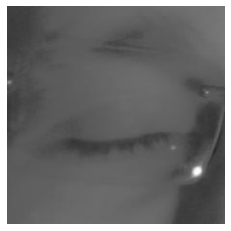

In [8]:
# 以OpenCV檢視輸入影像
import cv2
import matplotlib.pyplot as plt
import numpy as np
import requests

# 從網路獲取一張影像（更多眼睛照片資料集可參考 http://mrl.cs.vsb.cz/eyedataset）
file = requests.get("https://raw.githubusercontent.com/OmniXRI/Colab_DevCloud_OpenVINO_Samples/main/dataset/eye_open.png") # 張眼照
#file = requests.get("https://raw.githubusercontent.com/OmniXRI/Colab_DevCloud_OpenVINO_Samples/main/dataset/eye_closed.png") # 閉眼照

# 將影像轉成OpenCV格式存入img中
img = cv2.imdecode(np.frombuffer(file.content, np.uint8), 1)
# 將img寫入磁碟命名為input.jpg
cv2.imwrite('input.jpg',img)

# 亦可直接讀取本地端影像
# img = cv2.imread('input.jpg')

rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # 將影像從BGR格式轉到RGB格式，才能讓plt.imshow()正確顯示
plt.figure() # 準備一顯示影像空間
plt.axis("off") # 設定關閉XY軸刻尺
plt.imshow(rgb) # 顯示影像

# 5.進行推論

在OpenVINO中大部份的範例程式都放在/opt/intel/openvino_2021/deployment_tools/inference_engine/demos中，但影像辨識是最基本的範例，所以不在其中，而是放在/opt/intel/openvino_2021/inference_engine/samples/python/下。  
這裡使用/python/hello_classification/hello_classification.py來進行影像分類測試。這個範例適用上述數十種模型。    
另外要依據不同的模型所對應的資料集給予標籤檔案，預設放在/opt/intel/openvino_2021/deployment_tools/open_model_zoo/data/dataset_classes下。

輸入參數：  
-i 輸入影像名稱 (.png, .jpg ...)  
-m 模型名稱 (.xml)  
-nt 輸出置信度排序最高的前幾項（選配參數，預設為Top 10）  
--labels 標籤名稱檔(.txt) （選配參數，不使用時會以id編號輸出，這個範例不使用）  

最後顯示推論結果，包括分類編號(classid)及置信度(probability)  

In [9]:
# 設定環境變數執行影像分類推論
# 張眼分類編號(Classid)為1,閉眼為0
!source /opt/intel/openvino_2021/bin/setupvars.sh && \
python3 \
/opt/intel/openvino_2021/inference_engine/samples/python/hello_classification/hello_classification.py \
-i 'input.jpg' \
-m public/open-closed-eye-0001/FP32/open-closed-eye-0001.xml 

[setupvars.sh] OpenVINO environment initialized
[ INFO ] Creating Inference Engine
[ INFO ] Loading network:
	public/open-closed-eye-0001/FP32/open-closed-eye-0001.xml
[ INFO ] Preparing input blobs
[ WARNING ] Image input.jpg is resized from (180, 180) to (32, 32)
[ INFO ] Loading model to the plugin
[ INFO ] Starting inference in synchronous mode
[ INFO ] Processing output blob
[ INFO ] Top 10 results: 
Image input.jpg

classid probability
------- -----------
   0     0.9999882
   1     0.0000118


[ INFO ] This sample is an API example, for any performance measurements please use the dedicated benchmark_app tool

